# Air Quality Index (AQI) Prediction

1. Importing all necessary libraries


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


2. Data Loading and Preprocessing

In [42]:
#Load the data set and display basic info
df = pd.read_csv('city_day.csv')
print(df.shape)
df.head()


(29531, 16)


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [43]:
# Drop columns with mostly null values or that are not needed, Keeping only numeric features.
df = df.drop(columns=['City', 'Date'])

# Convert AQI column to numeric (in case it's stored as string/object)
df['AQI'] = pd.to_numeric(df['AQI'], errors='coerce')

# Drop rows where target or key pollutants are missing
df.dropna(subset=['AQI', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3'], inplace=True)

# Fill remaining missing values (if any) with median
df.fillna(df.median(numeric_only=True), inplace=True)

df.describe()


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,16010.000000,16010.000000,16010.000000,16010.000000,16010.000000,16010.000000,16010.000000,16010.000000,16010.000000,16010.000000,16010.000000,16010.000000,16010.000000
mean,57.342885,117.697931,18.161290,29.112615,34.224680,20.248039,1.434911,12.785969,35.132273,3.503848,8.470423,1.898545,141.355715
std,52.096518,88.484088,23.152227,22.830288,31.204406,16.535824,3.548884,13.496148,21.525602,17.471331,19.549791,3.296495,104.325680
min,0.160000,0.180000,0.030000,0.010000,0.000000,0.060000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,14.000000
25%,25.040000,56.620000,5.180000,12.450000,14.562500,9.950000,0.560000,6.120000,19.680000,0.460000,2.060000,1.310000,74.000000
50%,42.910000,95.625000,10.265000,24.105000,25.900000,15.480000,0.840000,9.710000,31.965000,1.520000,4.590000,1.310000,107.000000
75%,69.800000,148.697500,20.950000,39.370000,42.660000,26.260000,1.247500,14.677500,46.200000,3.150000,8.160000,1.310000,167.000000
max,868.660000,847.410000,270.090000,277.310000,293.100000,207.140000,92.960000,186.080000,257.730000,455.030000,454.850000,125.180000,1389.000000


3. Feature selection, Scaling and Splitting the data

In [44]:
#Feature Selection

features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
target = 'AQI'

X = df[features]
y = df[target]


In [45]:
#Feature Scaling using standard scaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [46]:
#Splitting the data into training and test sets with 80:20 ratio with 80% of training data and 20% of testing data.

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


4. Exploratory Data Analysis

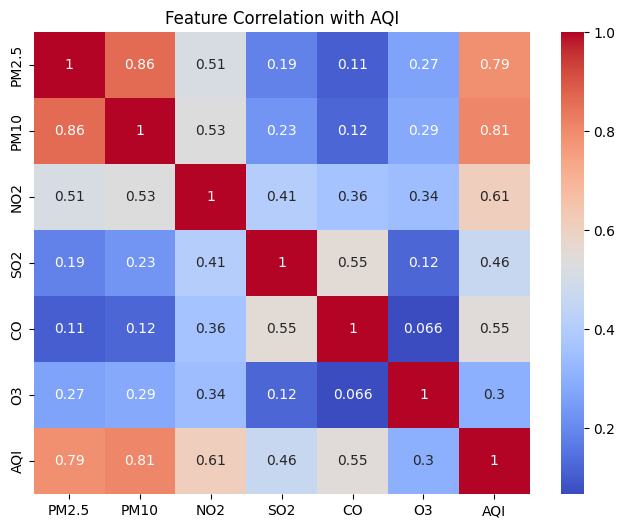

In [47]:

# Correlation Heatmap

plt.figure(figsize=(8,6))
sns.heatmap(df[features + ['AQI']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with AQI")
plt.show()



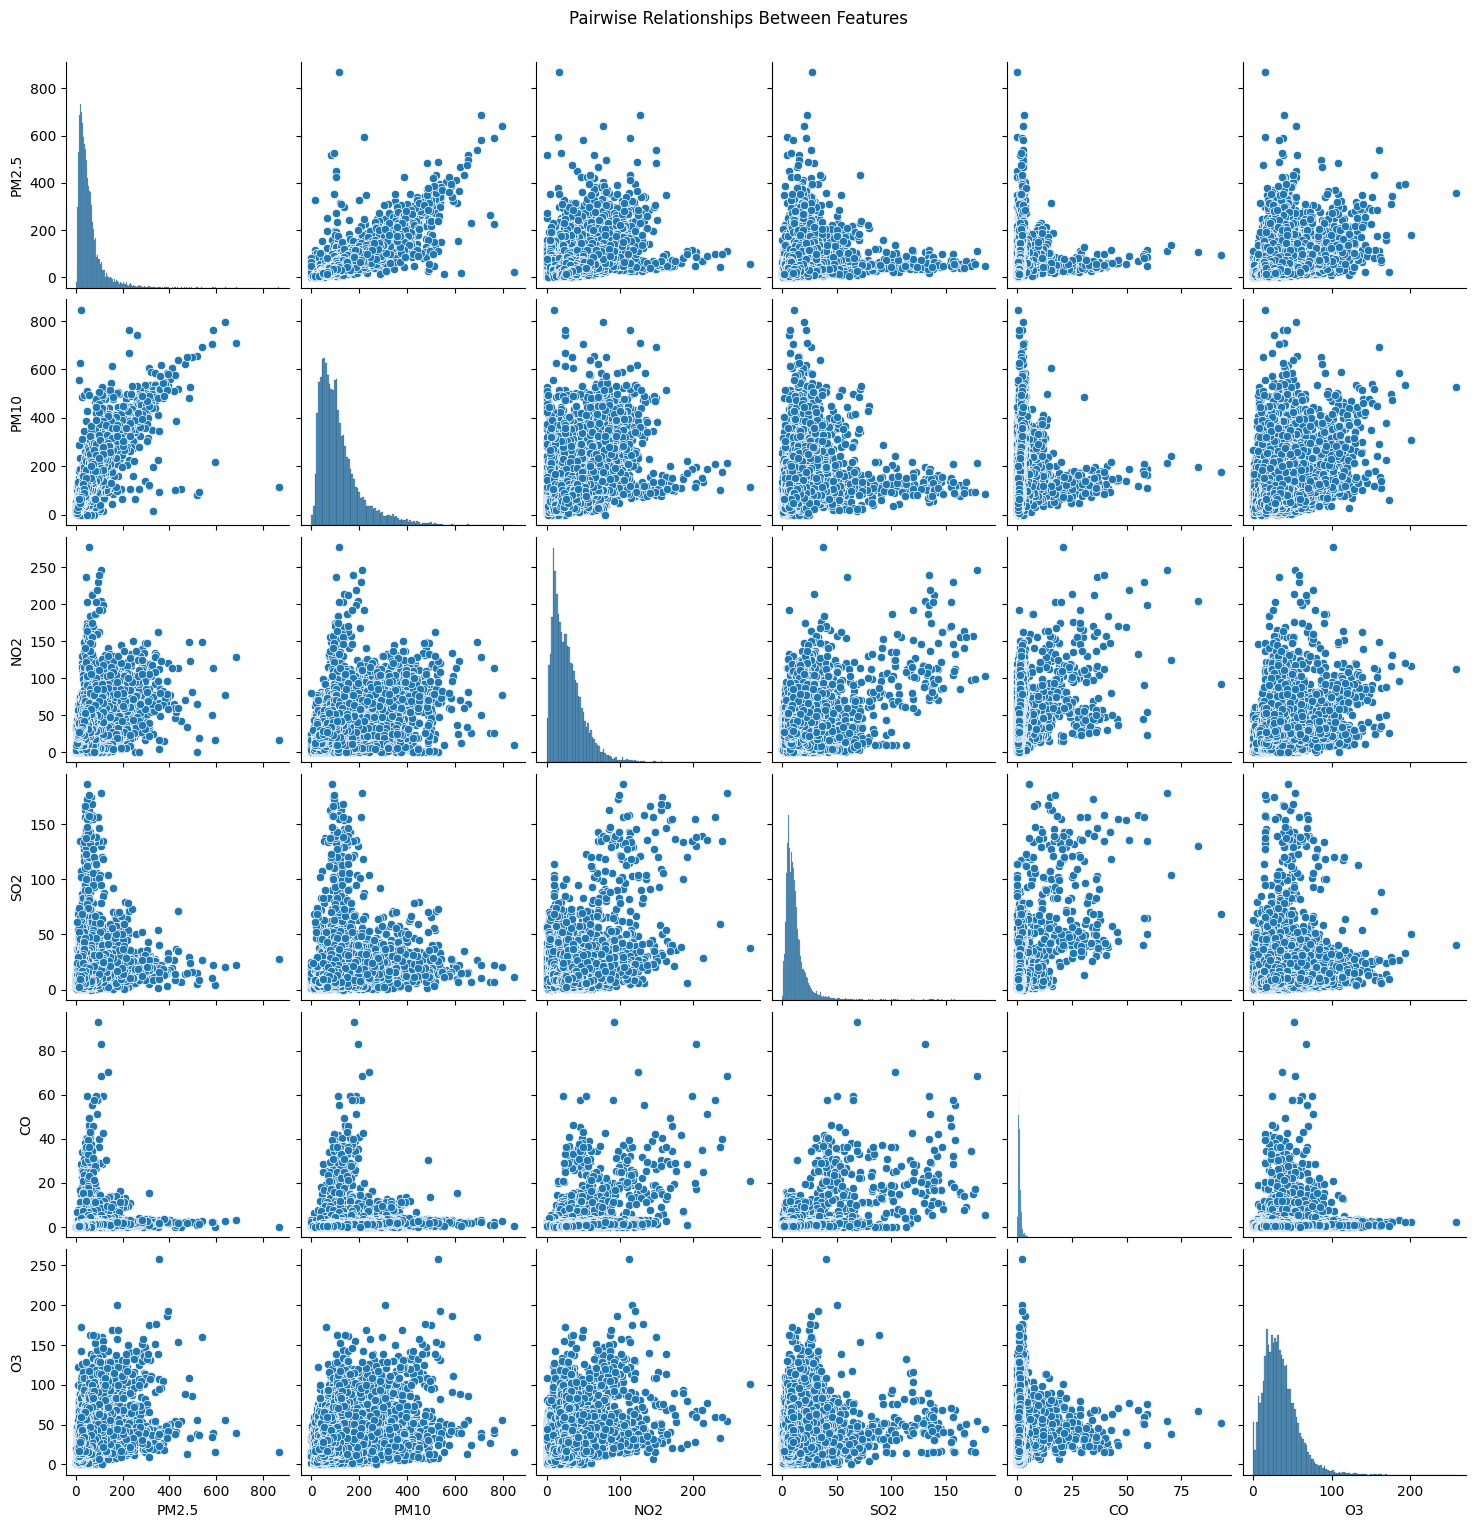

In [48]:
# Pairplot to see pairwise relationships
sns.pairplot(df[features])
plt.suptitle("Pairwise Relationships Between Features", y=1.02)
plt.show()

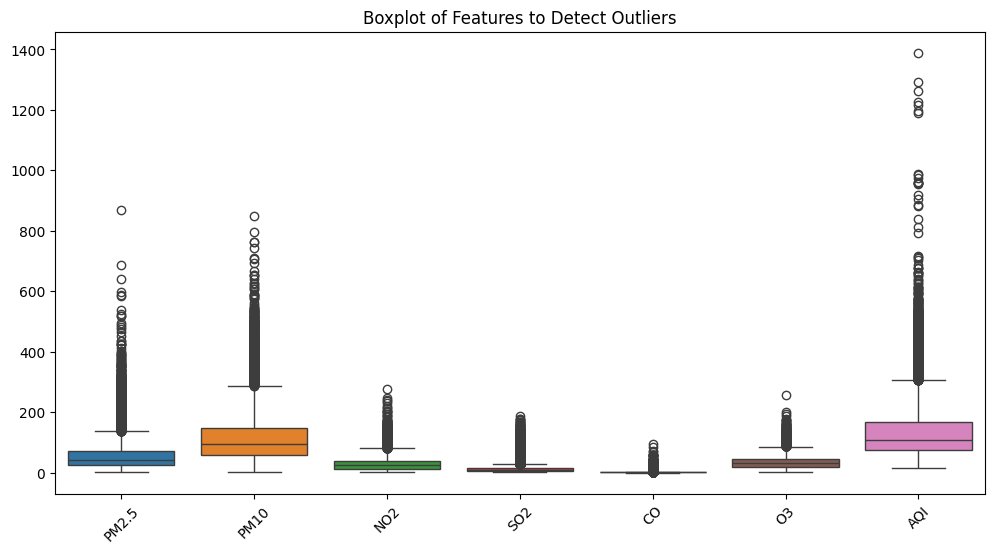

In [49]:
#Boxplot to detect the outliers present

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[features + ['AQI']])
plt.title("Boxplot of Features to Detect Outliers")
plt.xticks(rotation=45)
plt.show()


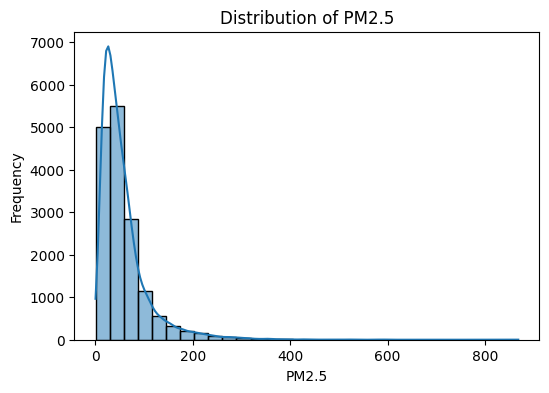

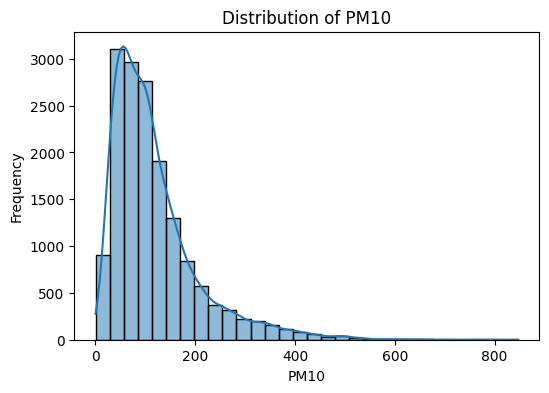

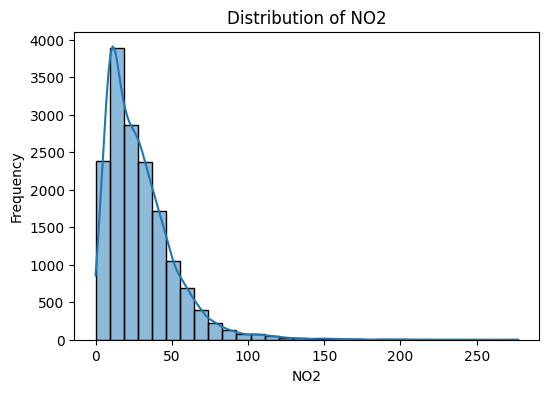

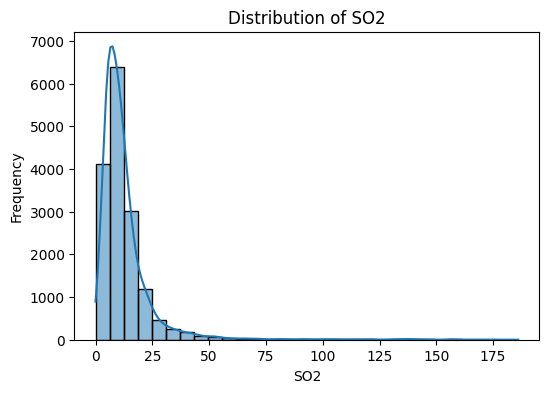

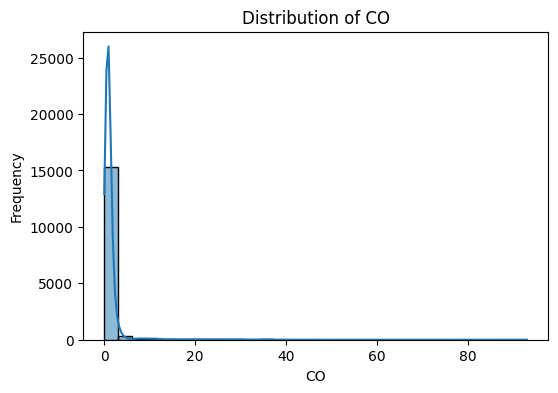

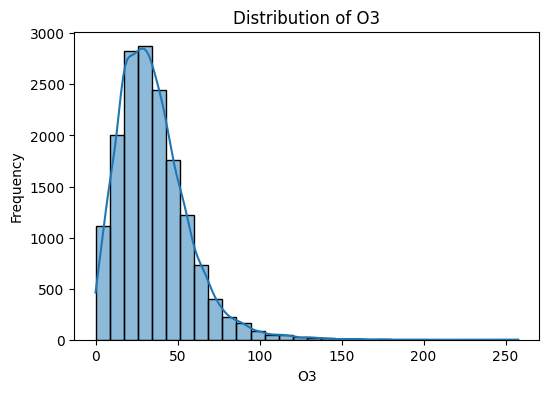

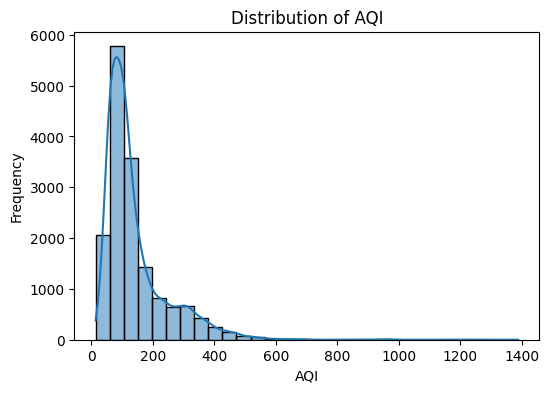

In [50]:
#Distribution of features
for col in features + ['AQI']:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


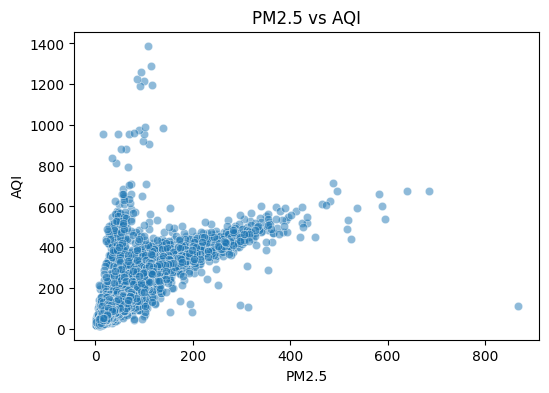

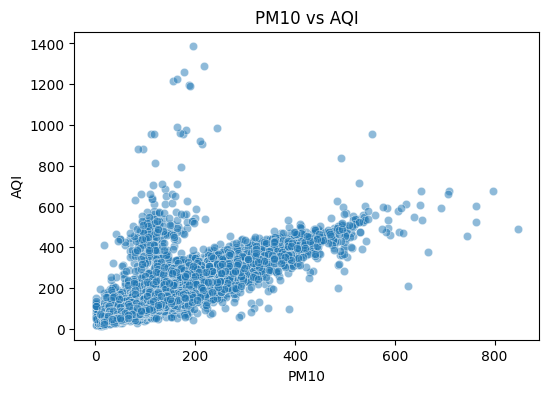

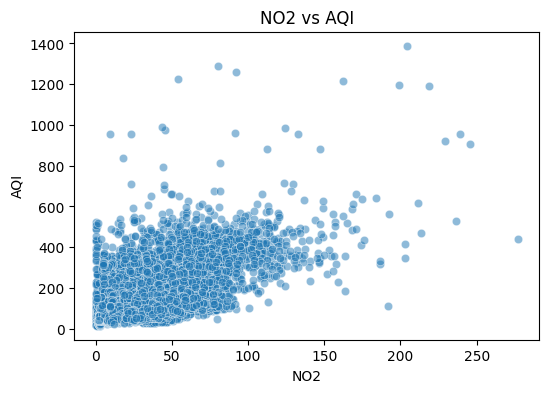

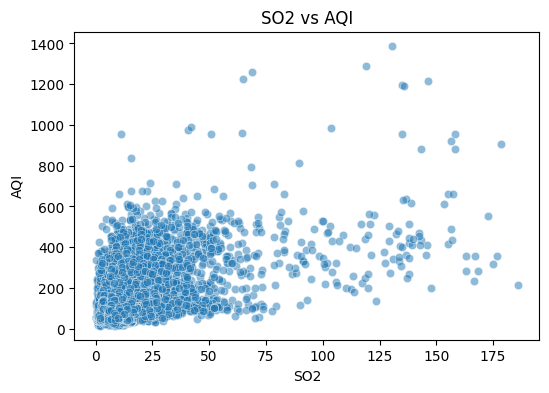

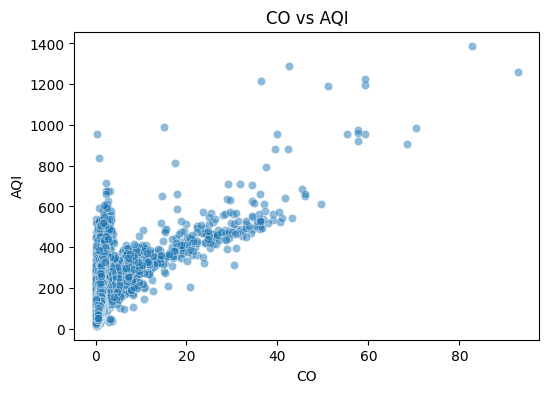

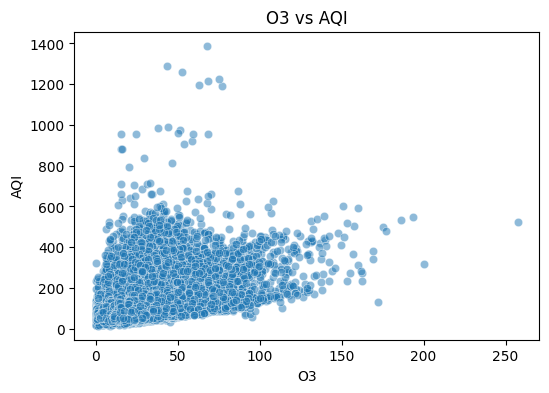

In [51]:
for col in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=col, y='AQI', alpha=0.5)
    plt.title(f"{col} vs AQI")
    plt.xlabel(col)
    plt.ylabel("AQI")
    plt.show()


5. Model Training: Random Forest Regressor
* Random Forest is chosen because it handles nonlinear relationships. And it is robust, accurate.



In [52]:
#Model Training
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


6. Performance evaluation
##### To evaluate the performance of the model we use few performance measure. Here we used:
* MAE (Mean absolute error)
* MSE (Mean squared error)
* R2 score



In [53]:
#Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 16.59
RMSE: 28.82
R² Score: 0.92


#### Comparision with benchmark model(Lasso & Ridge)

In [54]:
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_r2 = r2_score(y_test, ridge_pred)

print("\nRidge Regression Performance:")
print(f"MAE: {ridge_mae:.2f}")
print(f"RMSE: {ridge_rmse:.2f}")
print(f"R²: {ridge_r2:.2f}")

# Lasso Regression
lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

lasso_mae = mean_absolute_error(y_test, lasso_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_r2 = r2_score(y_test, lasso_pred)

print("\nLasso Regression Performance:")
print(f"MAE: {lasso_mae:.2f}")
print(f"RMSE: {lasso_rmse:.2f}")
print(f"R²: {lasso_r2:.2f}")




Ridge Regression Performance:
MAE: 21.14
RMSE: 33.10
R²: 0.90

Lasso Regression Performance:
MAE: 21.27
RMSE: 33.14
R²: 0.90


7. Hyperparameter tuning
##### Hyperparameter tuning is done with GridSearchCV and best parameters are found.
Performance is evaluated also after tuning.

In [55]:
#Hyperparameter tuning

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                           cv=3, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
best_pred = best_model.predict(X_test)

# Evaluate best model
best_mae = mean_absolute_error(y_test, best_pred)
best_rmse = np.sqrt(mean_squared_error(y_test, best_pred))
best_r2 = r2_score(y_test, best_pred)

print(f"Tuned MAE: {best_mae:.2f}")
print(f"Tuned RMSE: {best_rmse:.2f}")
print(f"Tuned R² Score: {best_r2:.2f}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Tuned MAE: 16.22
Tuned RMSE: 27.48
Tuned R² Score: 0.93


#### Visualizations of predictions

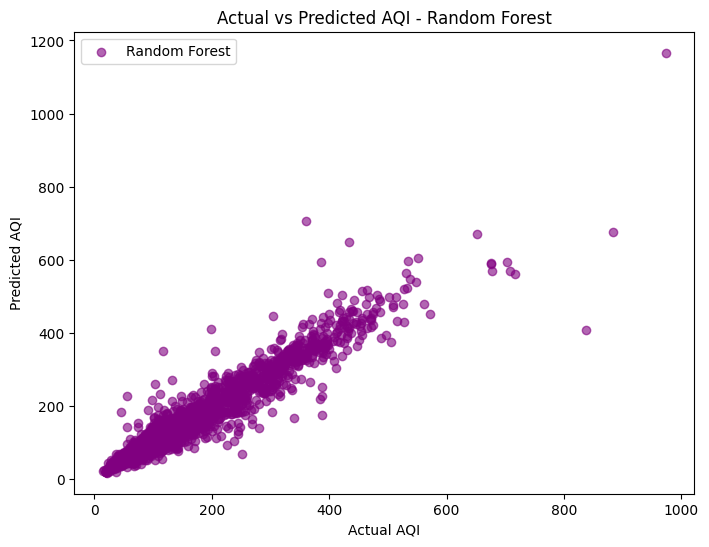

In [60]:
# Plot actual vs predicted AQI
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple', label='Random Forest')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI - Random Forest")
plt.legend()
plt.show()




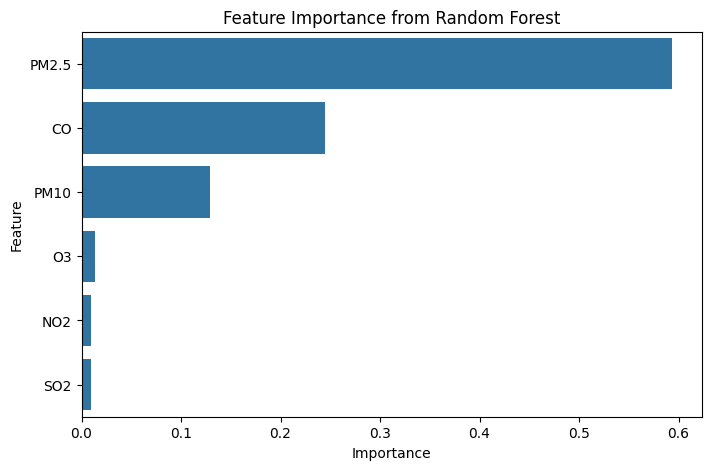

In [61]:
#Bar chart to show feature importance.
importances = best_model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title("Feature Importance from Random Forest")
plt.show()
